In [1]:
# Import libraries
import pandas as pd
pd.plotting.register_matplotlib_converters()
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import re
from datetime import datetime
from sklearn.ensemble import IsolationForest
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from pylab import rcParams
from sklearn.ensemble import IsolationForest

In [2]:
# Read data
df = pd.read_csv('./Data/cleaned_data.csv')
df.head()

,Page,2016-01-01 0:00,2016-01-02 0:00,2016-01-03 0:00,2016-01-04 0:00,2016-01-05 0:00,2016-01-06 0:00,2016-01-07 0:00,2016-01-08 0:00,2016-01-09 0:00,...,2016-12-22 0:00,2016-12-23 0:00,2016-12-24 0:00,2016-12-25 0:00,2016-12-26 0:00,2016-12-27 0:00,2016-12-28 0:00,2016-12-29 0:00,2016-12-30 0:00,2016-12-31 0:00
0,!vote_en,9,6,6,5,8,1,3,3,11,...,8,2,14,8,2,2,8,7,3,1
1,"""Weird_Al""_Yankovic_en",4440,4200,4302,4301,4173,4315,3857,4080,4082,...,3974,3726,3245,3066,3299,4537,4140,5290,4109,4146
2,(1)_Ceres_de,254,274,211,362,254,265,249,215,165,...,170,98,84,108,123,151,179,173,152,137
3,(500)_Days_of_Summer_es,452,630,598,564,451,440,381,374,398,...,1024,754,881,1031,1387,2943,1631,916,2572,986
4,.bn_ru,3,5,3,5,5,2,4,4,6,...,11,7,9,27,10,12,9,8,17,16


In [3]:
# Fill missing values
df = df.fillna(0)

In [4]:
# Reshaping the dataframe
df_reshaped = pd.melt(df,id_vars=['Page'],var_name='Date',value_name='Views')
df_reshaped.head()

,Page,Date,Views
0,!vote_en,2016-01-01 0:00,9
1,"""Weird_Al""_Yankovic_en",2016-01-01 0:00,4440
2,(1)_Ceres_de,2016-01-01 0:00,254
3,(500)_Days_of_Summer_es,2016-01-01 0:00,452
4,.bn_ru,2016-01-01 0:00,3


In [5]:
# Setting 'Date' column as the index 
df_reshaped['Date'] = pd.DatetimeIndex(df_reshaped['Date'])
df_reshaped = df_reshaped.set_index('Date')

In [6]:
# Top 5 pages with maximum number of views
top_pages = df_reshaped.groupby('Page')['Views'].sum().reset_index()
top_pages_list = top_pages.nlargest(5,'Views')['Page'].tolist()

## Time series analysis

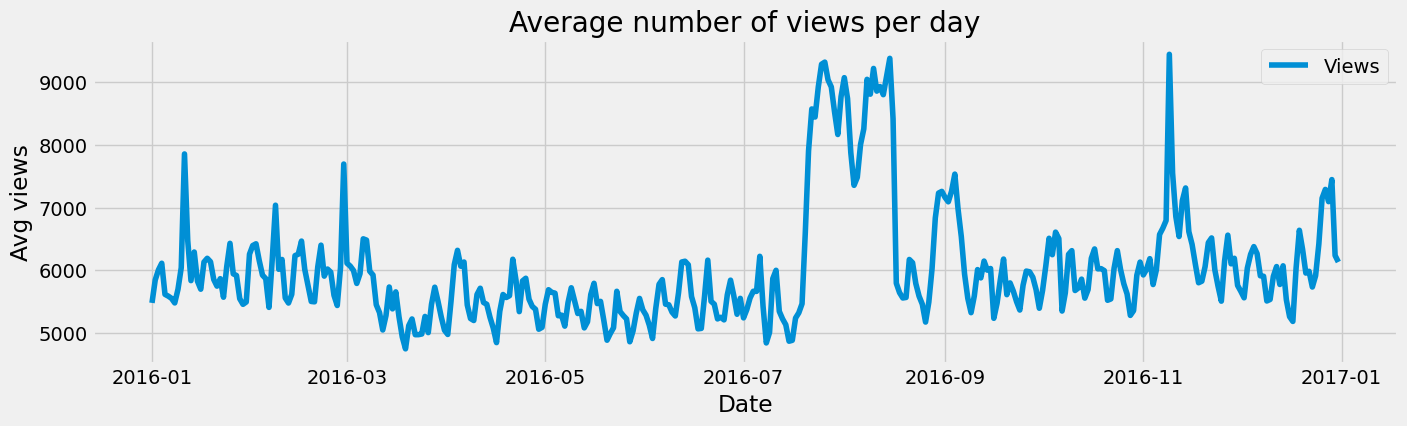

In [7]:
# Average number of views per day
temp = df_reshaped.groupby('Date')['Views'].mean()
plt.figure(figsize=(15,4))
plt.xlabel('Date')
plt.ylabel('Avg views')
plt.title('Average number of views per day')
plt.plot(temp,label='Views')
plt.legend()
plt.show()

In [8]:
# Average number of views per month
# month_index = df_reshaped.index.month
# views_by_month = df_reshaped.groupby(month_index).mean()
# months=['January','February','March','April','May','June','July','August','September','October','November','December']
# ax = views_by_month.plot()
# start, end = ax.get_xlim()
# plt.xticks(np.arange(start+0.5, end+0.5, 1.0))
# ax.set_xticklabels(months,rotation=75)
# ax.set_xlabel('Month')
# ax.set_ylabel('Average views')
# ax.set_title('Average number of views per month')
# plt.show()

In [9]:
# Time-series of page with maximum views
top_page_df = df_reshaped[df_reshaped.Page == top_pages_list[0]]
top_page_df = top_page_df[['Views']]
top_page_df['Views'] = top_page_df['Views'].div(1000000).round(2)
top_page_df.head()

,Views
Date,
2016-01-01,32.58
2016-01-02,35.11
2016-01-03,34.93
2016-01-04,38.38
2016-01-05,36.19


## Anomaly detection using Isolation Forest

In [10]:
isolation_forest_model = IsolationForest(contamination=0.08)
isolation_forest_model.fit(top_page_df)
top_page_df['anomaly'] = isolation_forest_model.predict(top_page_df)

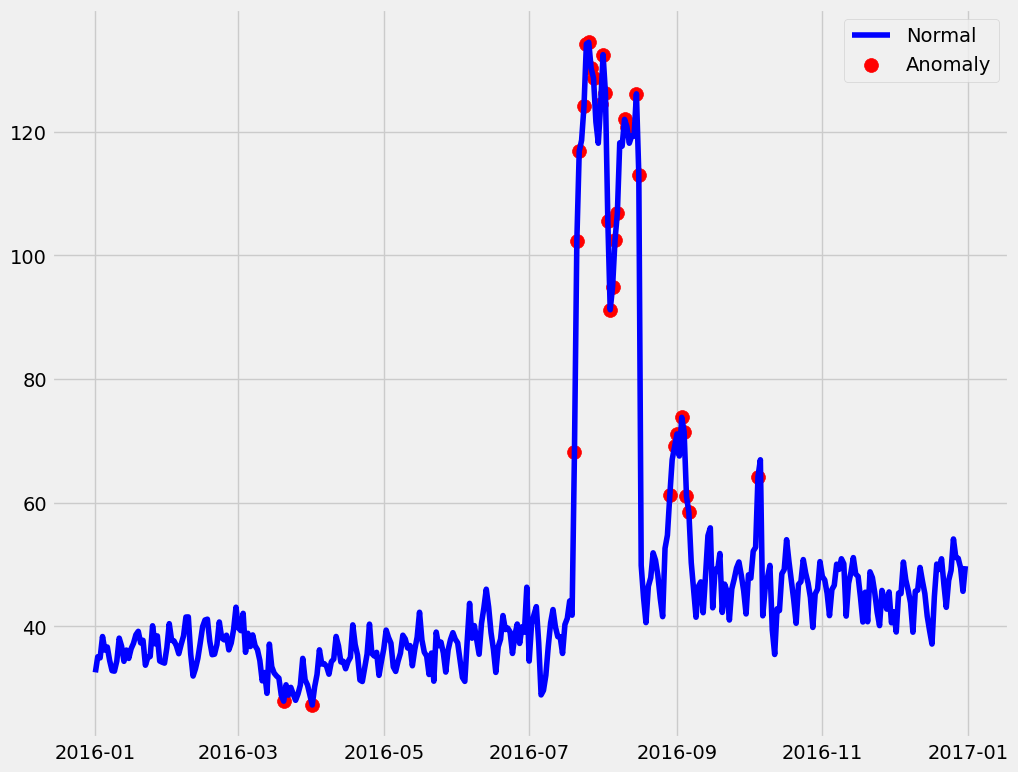

In [11]:
fig, ax = plt.subplots(figsize=(11,9))
anomaly_df = top_page_df.loc[top_page_df['anomaly'] == -1].copy()
ax.plot(top_page_df.index,top_page_df['Views'],color='blue', label = 'Normal')
plt.scatter(anomaly_df.index,anomaly_df['Views'],color='red',s=100,label = 'Anomaly')
plt.legend()
plt.show()

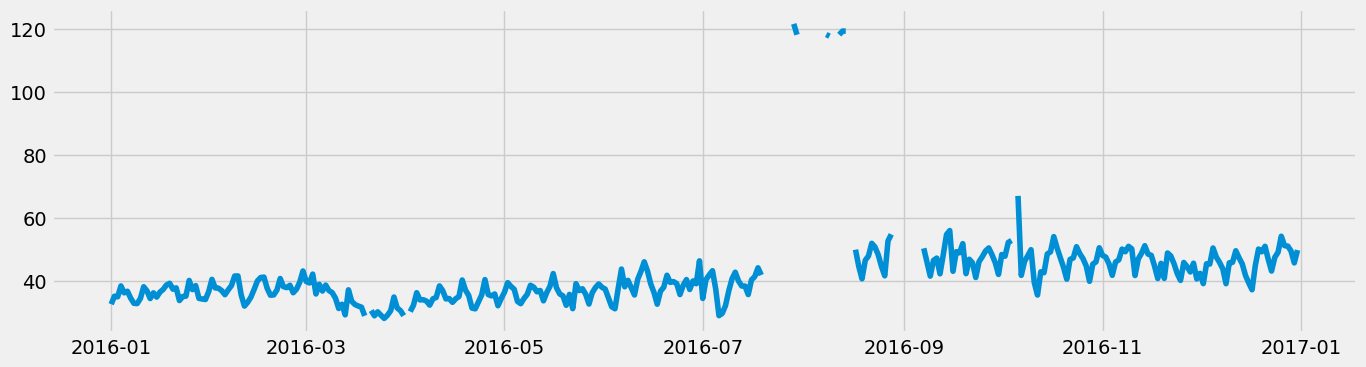

In [12]:
# Removing anomalies from the data
top_page_df['new_views'] = top_page_df.apply(lambda row: row.Views if row.anomaly == 1 else None, axis='columns')
plt.figure(figsize=(15,4))
plt.plot(top_page_df.index,top_page_df.new_views)

- Removing anomalies in the data creates some missing values.
- The missing values are filled with rolling mean or moving average of 30 days.

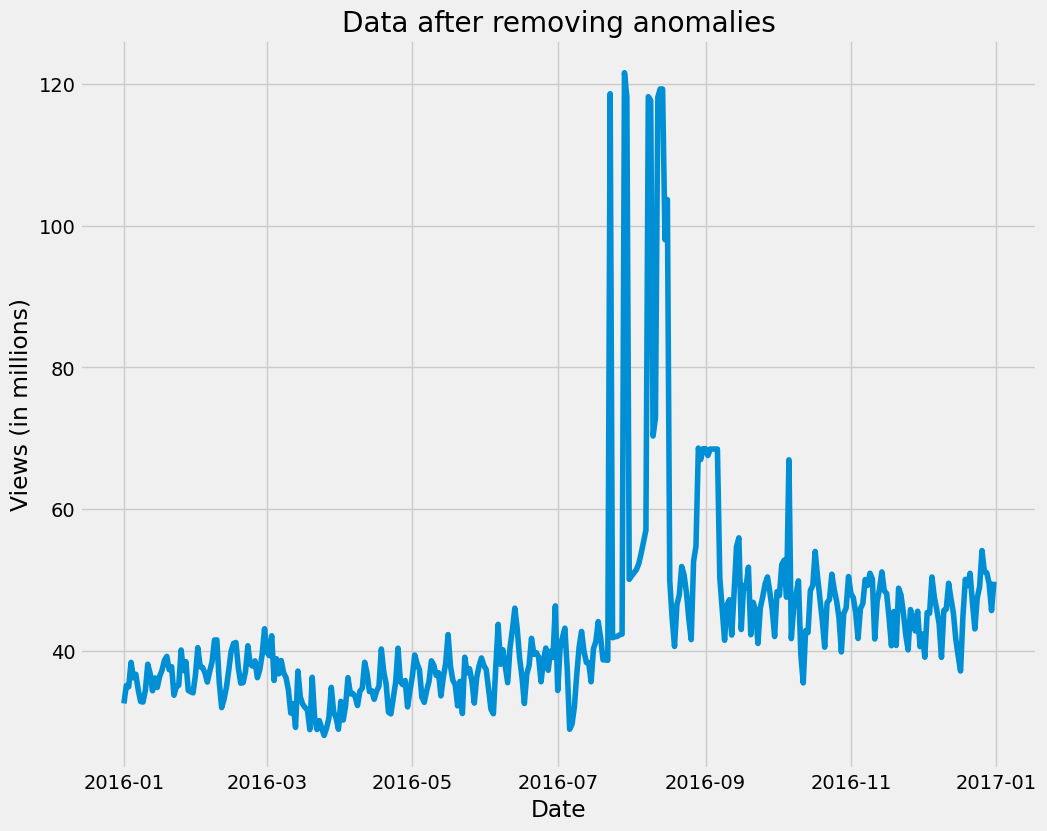

In [13]:
# Filling missing data with rolling mean
top_page_df = top_page_df.assign(rolling_mean=top_page_df.new_views.fillna(top_page_df.new_views.rolling(30,min_periods=1).mean()))

plt.figure(figsize=(11,9))
plt.plot(top_page_df.index,top_page_df.rolling_mean)
plt.title('Data after removing anomalies')
plt.xlabel('Date')
plt.ylabel('Views (in millions)')
plt.show()

In [14]:
top_page_df = top_page_df.drop(columns=['Views','anomaly','new_views']).rename(columns={'rolling_mean':'Views'})

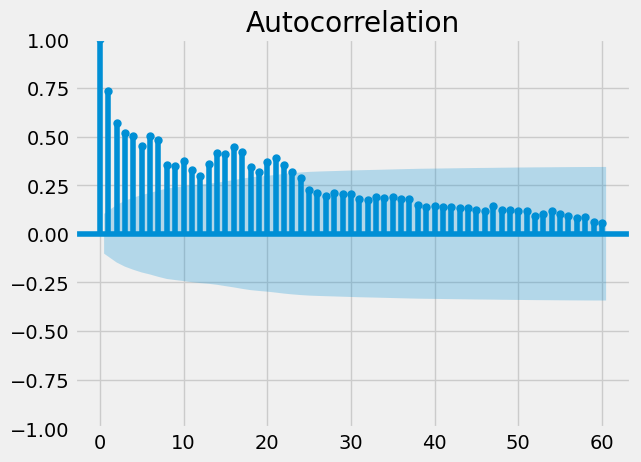

In [15]:
fig = tsaplots.plot_acf(top_page_df['Views'], lags=60)
plt.show()

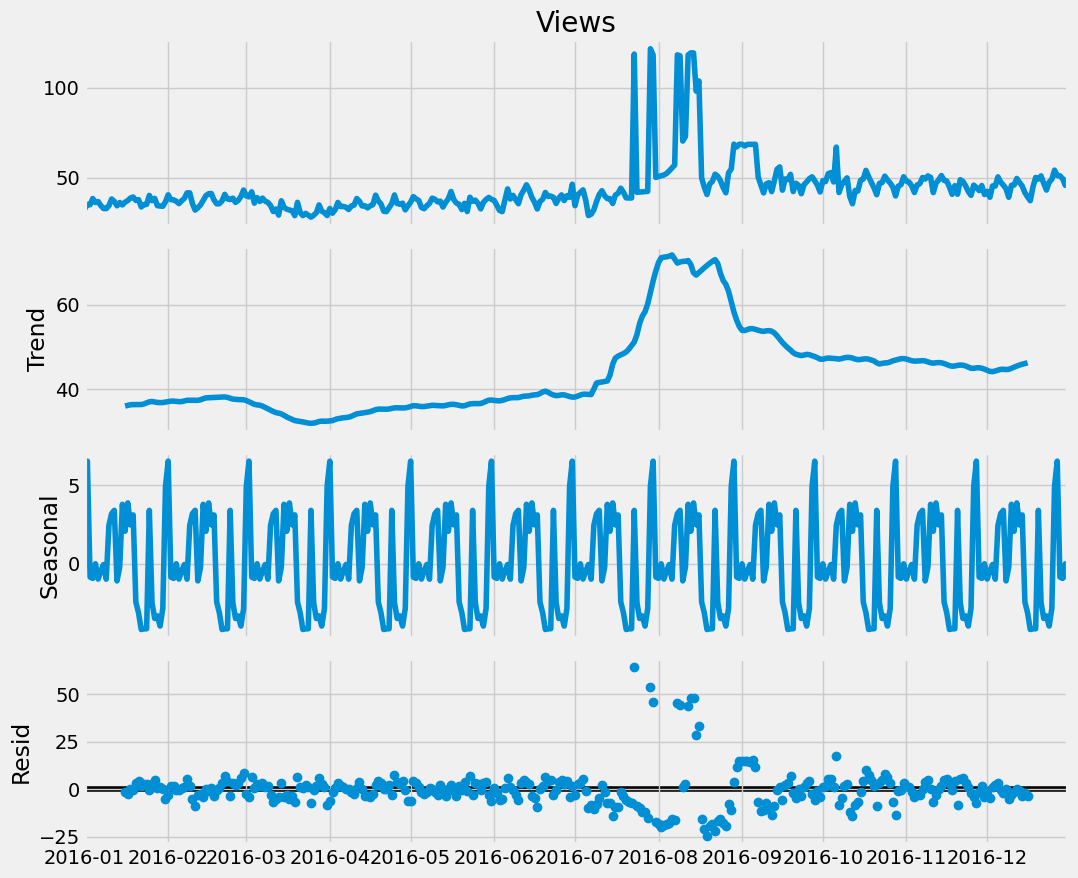

In [16]:
rcParams['figure.figsize'] = 11,9
ts_decomposition = sm.tsa.seasonal_decompose(top_page_df.Views, period=30)
figure = ts_decomposition.plot()

### Augmented Dicky-Fuller test

In [17]:
test = adfuller(top_page_df['Views'])
print(test)

(-2.0994943719048647, 0.2447179657042543, 13, 352, {'1%': -3.4490648539347544, '5%': -2.8697861692116478, '10%': -2.5711631253228306}, 2538.823242321844)


 - First element is the test statistic. Test statistic shows how likely the data is stationary.
 - Second element indicates the p-value. Since the p-value is not < 0.05, we cannot reject null hypothesis. The null hypothesis is that data is not stationary. Therefore, data is not stationary.

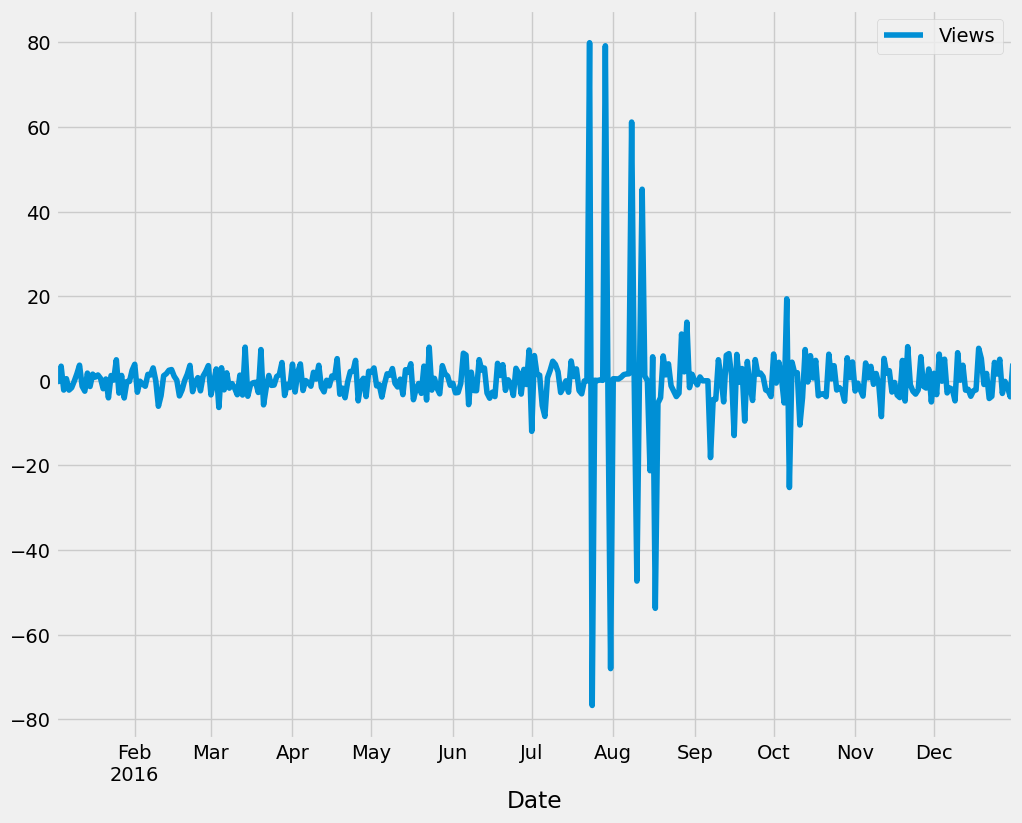

In [18]:
# Differencing the data to make it stationary
top_page_stationary_df = top_page_df.diff().dropna()
ax = top_page_stationary_df.plot()

In [19]:
# Augmented dicky-fuller test on stationary data
test2 = adfuller(top_page_stationary_df['Views'])
print(test2)

(-8.619825087939182, 6.148029158613695e-14, 14, 350, {'1%': -3.4491725955218655, '5%': -2.8698334971428574, '10%': -2.5711883591836733}, 2534.615179585295)


- We can see that the test statistic is more for stationary data. This means that the data is now more likely to be stationary.
- Since the p-value(second element) is less than 0.05, null hypothesis can be rejected. Therefore, data is stationary.

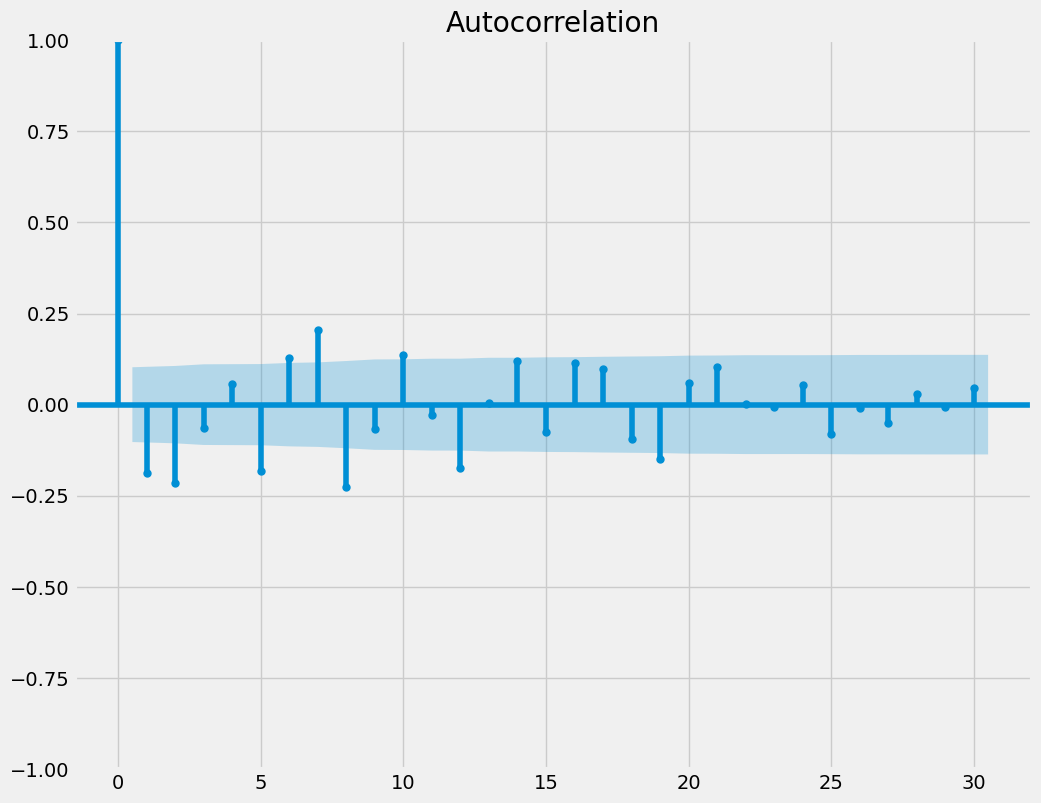

In [20]:
fig = tsaplots.plot_acf(top_page_stationary_df['Views'], lags=30)
plt.show()

## Preparing the data for modeling

In [21]:
train = top_page_df[:'2016-09']
test = top_page_df['2016-10':]

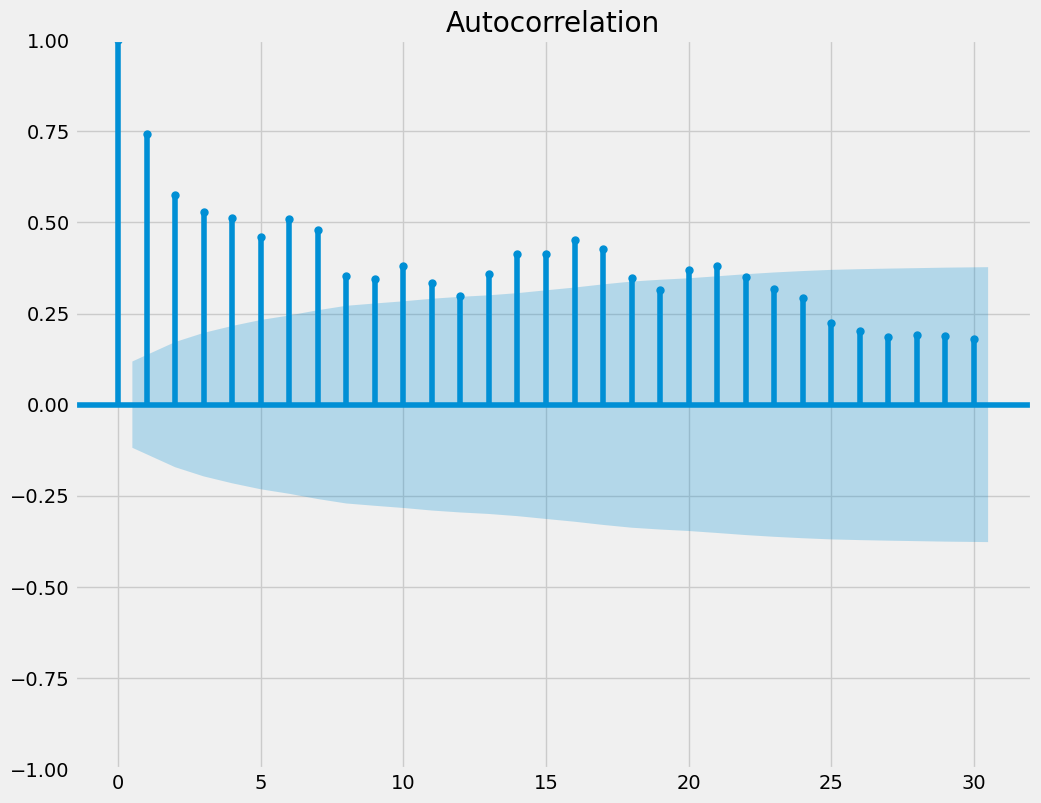

In [22]:
fig = tsaplots.plot_acf(train['Views'], lags=30)
plt.show()

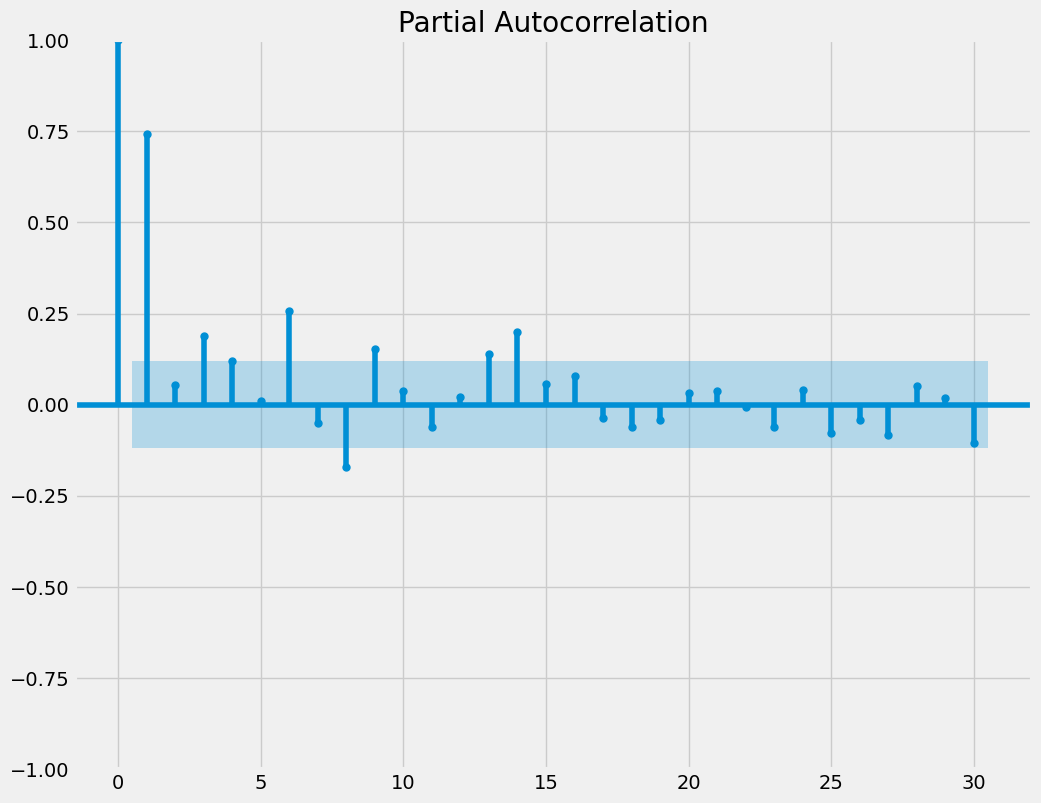

In [23]:
fig = tsaplots.plot_pacf(train['Views'], lags=30)
plt.show()

## ARIMA model

In [24]:
arima_aic_bic = []
for p in range(7):
    for q in range(7):
        try:
            arima_model = SARIMAX(train, order=(p,1,q))
            arima_result = arima_model.fit()
            arima_aic_bic.append((p,q,arima_result.aic,arima_result.bic))
        except:
            continue

arima_aic_bic_df = pd.DataFrame(arima_aic_bic,columns=['p','q','aic','bic'])
arima_aic_bic_df = arima_aic_bic_df.sort_values(by=['aic','bic'])

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-p

### Prediction using ARIMA

In [25]:
aic_bic_values = []
aic_bic_df = pd.DataFrame(aic_bic_values,columns=['p','q','aic','bic'])
aic_bic_df = aic_bic_df.sort_values(by=['aic','bic'])

In [26]:
arima_model = SARIMAX(train,order=(int(arima_aic_bic_df.iloc[0]['p']),1,int(arima_aic_bic_df.iloc[0]['q'])))
arima_result = arima_model.fit()
arima_forecast_mean = arima_result.get_prediction(steps=-30).predicted_mean

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


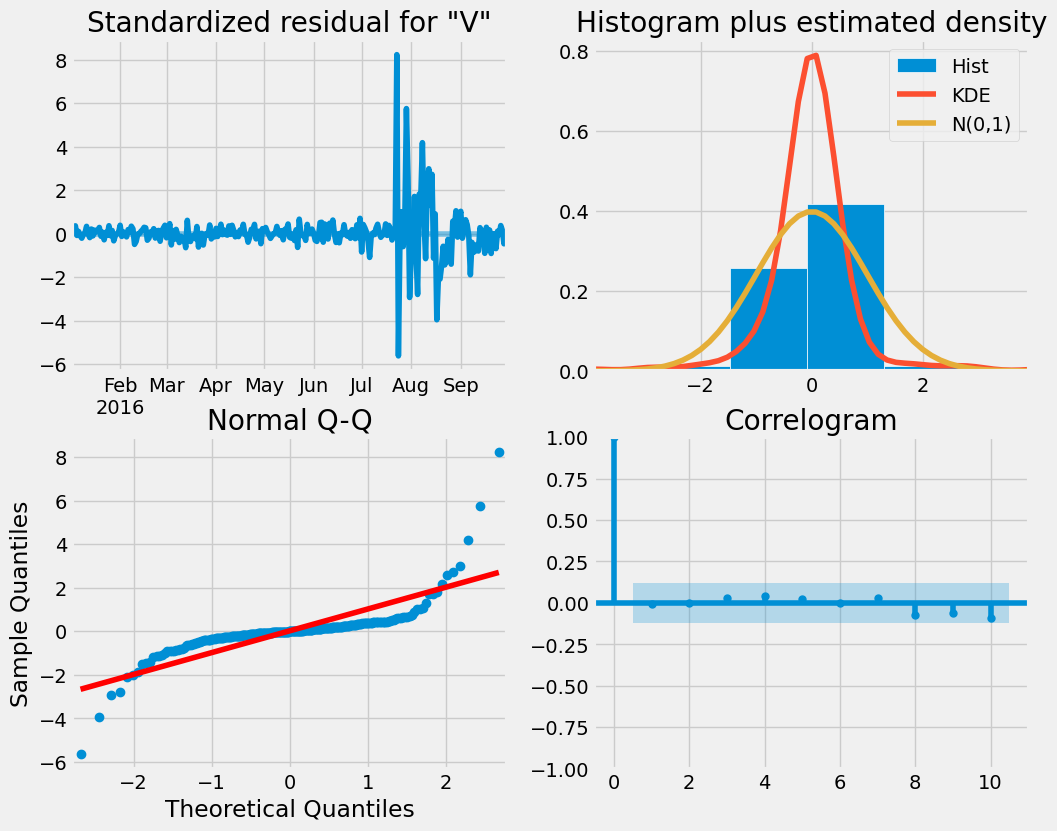

In [27]:
arima_result.plot_diagnostics()
plt.show()

In [28]:
#arima_result.summary()
arima_forecast_mean

arima_forecast_values = arima_result.get_forecast(steps=test.shape[0])
arima_forecast_mean = arima_forecast_values.predicted_mean


# Convert the ARIMA forecast values to a DataFrame
arima_forecast_df = pd.DataFrame({
    'Date': test.index,
    'Forecasted_Views': arima_forecast_mean
})

# Export the DataFrame to a CSV file
arima_forecast_df.to_csv('arima_forecast_values.csv', index=False)

print("ARIMA forecast values have been exported to arima_forecast_values.csv.")

ARIMA forecast values have been exported to arima_forecast_values.csv.


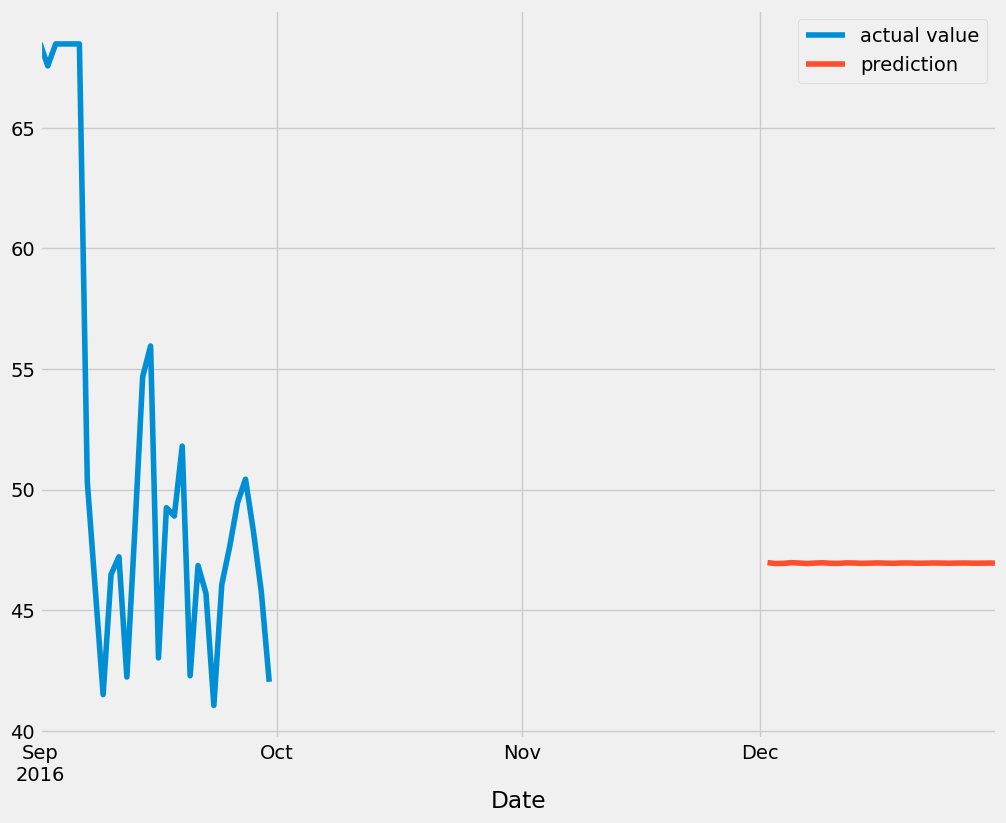

In [29]:
fig,ax=plt.subplots()
train[-30:].rename(columns={'Views':'actual value'}).plot(ax=ax)
arima_forecast_mean[-30:].plot(ax=ax,label='prediction')
plt.legend()
plt.show()

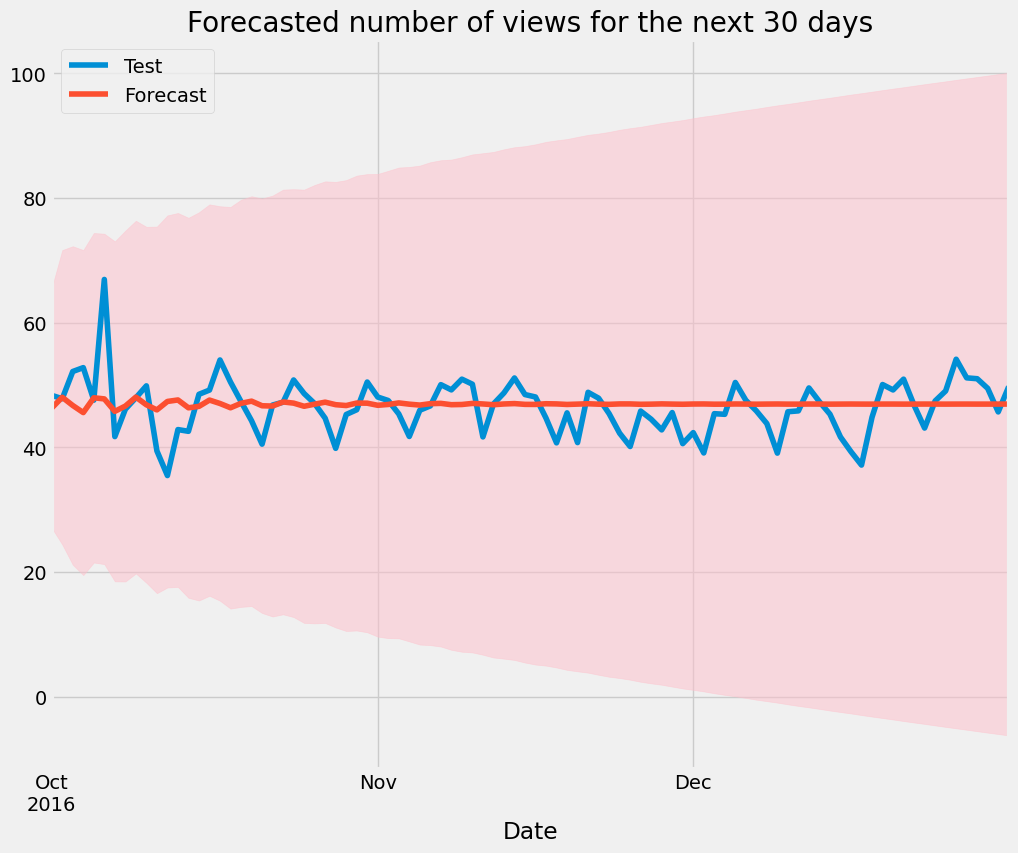

In [30]:
arima_forecast_values = arima_result.get_forecast(steps=test.shape[0])
arima_forecast_mean = arima_forecast_values.predicted_mean
arima_conf_interval = arima_forecast_values.conf_int()

arima_forecast_df = pd.DataFrame({'Date':test.index,'Views':arima_forecast_values.predicted_mean,'lower_views':arima_conf_interval['lower Views'].values,'upper_views':arima_conf_interval['upper Views'].values})
arima_forecast_df = arima_forecast_df.set_index('Date')

fig,ax=plt.subplots()
test.rename(columns={'Views':'Test'}).plot(ax=ax)
arima_forecast_df[['Views']].rename(columns={'Views':'Forecast'}).plot(ax=ax)
plt.fill_between(arima_forecast_df.index, \
                arima_forecast_df.lower_views, \
                arima_forecast_df.upper_views, \
                color='pink', alpha=0.5)
plt.title('Forecasted number of views for the next 30 days')
plt.legend()
plt.show()

In [31]:
rmse_values = []
rmse_values.append(('ARIMA',np.sqrt(np.mean(np.square(arima_forecast_df.Views.values - test.Views.values)))))

## Auto-Arima

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2079.865, Time=1.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2124.995, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2118.559, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2106.152, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2122.997, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2077.877, Time=1.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2079.941, Time=0.67 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2078.353, Time=0.46 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2074.993, Time=0.32 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2077.660, Time=0.29 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2073.774, Time=0.25 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2067.517, Time=2.11 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2081.566, Time=0.43 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=2069.806, Time=0.47 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept

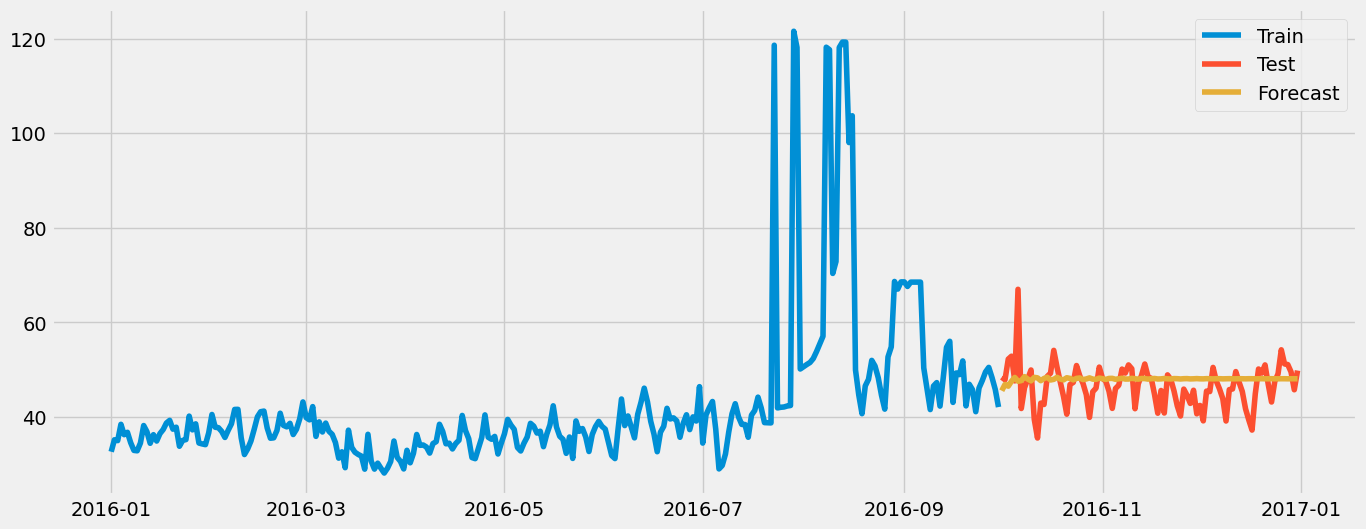

In [32]:
auto_arima_model = auto_arima(train,start_p=2,max_p=7,start_q=2,max_q=7, m=1,stationary=False,trace=True, seasonal=False,error_action='ignore',suppress_warnings=True)
auto_arima_model.fit(train)

auto_arima_forecast = auto_arima_model.predict(n_periods=test.shape[0])
auto_arima_forecast = pd.DataFrame(auto_arima_forecast,index = test.index,columns=['Forecast'])

plt.figure(figsize=(15,6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(auto_arima_forecast, label='Forecast')
plt.legend()
plt.show()

In [33]:
rmse_values.append(('Auto-arima',np.sqrt(np.mean(np.square(auto_arima_forecast.values - test.Views.values)))))

### Root Mean Squared Error

In [34]:
rmse_df = pd.DataFrame(rmse_values,columns=['Model','RMSE_values']).sort_values('RMSE_values')
rmse_df

,Model,RMSE_values
0,ARIMA,4.405315
1,Auto-arima,4.670615


In [35]:
# Import necessary libraries
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime

# Function to predict views for a given page and date
def predict_views(page_name, prediction_date):
    """
    Predicts the number of views for a given page and date using a trained ARIMA model.

    Args:
        page_name (str): The name of the page for which to predict views.
        prediction_date (str): The date (YYYY-MM-DD) for which to predict views.

    Returns:
        float: Predicted number of views for the specified page and date.
    """
    # Ensure the date is in datetime format
    prediction_date = pd.to_datetime(prediction_date)

    # Filter data for the specified page
    page_data = df_reshaped[df_reshaped['Page'] == page_name][['Views']].copy()

    if page_data.empty:
        raise ValueError(f"No data found for page '{page_name}'.")

    # Handle missing values using rolling mean
    page_data['Views'] = page_data['Views'].fillna(page_data['Views'].rolling(30, min_periods=1).mean())
    
    # Train-test split (up to the latest available date for training)
    train_data = page_data.loc[:prediction_date - pd.Timedelta(days=1)]

    # Train the ARIMA model
    arima_model = SARIMAX(train_data, order=(2, 1, 2))  # You can adjust (p, d, q) based on earlier tuning
    arima_result = arima_model.fit(disp=False)

    # Predict views for the specified date
    steps = (prediction_date - train_data.index[-1]).days
    if steps <= 0:
        raise ValueError("Prediction date must be in the future relative to training data.")

    forecast = arima_result.get_forecast(steps=steps)
    prediction = forecast.predicted_mean.iloc[-1]

    return max(0, prediction)  # Ensure no negative predictions

# Example usage
page_name = "13_Hours:_The_Secret_Soldiers_of_Benghazi_en"  # Replace with actual page name
prediction_date = "2016-01-31"  # Replace with desired date (YYYY-MM-DD)
try:
    predicted_views = predict_views(page_name, prediction_date)
    print(f"Predicted views for '{page_name}' on {prediction_date}: {predicted_views}")
except Exception as e:
    print(str(e))


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Predicted views for '13_Hours:_The_Secret_Soldiers_of_Benghazi_en' on 2016-01-31: 58513.814996915135


## Save the Trained ARIMA Model

In [36]:
import joblib

# Save the trained ARIMA model
model_file_path = "arima_model.pkl"
joblib.dump(arima_result, model_file_path)
print(f"Model saved to {model_file_path}")

Model saved to arima_model.pkl
